In [1]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pandas as pd
import numpy as np
import shap

In [2]:
df_master = pd.read_parquet('../master/master.parquet')

In [ ]:
df_master.iloc[332409]

In [ ]:
#df_master[df_master['isInsider'] == 1].groupby('user_id')['dateString'].agg('min', 'max')
df_master[df_master['isInsider'] == 1][['user_id','dateString']]

In [3]:
for colToStd in ['webCount','webQuestionableUsage','numExtEmails','sumExtEmailAttachments','sumExtEmailSize','countPC','hasConnect']:
    df_roleStd = df_master.groupby('role').apply(lambda x: (x[colToStd] - x[colToStd].mean())/x[colToStd].std()).to_frame()\
    .reset_index(level=0).drop('role', axis=1).rename(columns={colToStd:colToStd+'RoleStd'})
    df_master = df_master.join(df_roleStd)

In [4]:
for colToStd in ['webCount','webQuestionableUsage','numExtEmails','sumExtEmailAttachments','sumExtEmailSize','countPC','hasConnect']:
    df_roleStd = df_master.groupby('user_id').apply(lambda x: (x[colToStd] - x[colToStd].mean())/x[colToStd].std()).to_frame()\
    .reset_index(level=0).drop('user_id', axis=1).rename(columns={colToStd:colToStd+'UserStd'})
    df_master = df_master.join(df_roleStd)

In [5]:
for colToScale in ['webCount','webQuestionableUsage','numExtEmails','sumExtEmailAttachments','sumExtEmailSize','countPC','hasConnect']:
    df_roleScale = df_master.groupby('role').apply(lambda x: (x[colToScale] - x[colToScale].min())/(x[colToScale].max() - x[colToScale].min())).to_frame()\
    .reset_index(level=0).drop('role', axis=1).rename(columns={colToScale:colToScale+'RoleScale'})
    df_master = df_master.join(df_roleScale)

In [6]:
for colToScale in ['webCount','webQuestionableUsage','numExtEmails','sumExtEmailAttachments','sumExtEmailSize','countPC','hasConnect']:
    df_userScale = df_master.groupby('user_id').apply(lambda x: (x[colToScale] - x[colToScale].min())/(x[colToScale].max() - x[colToScale].min())).to_frame()\
    .reset_index(level=0).drop('user_id', axis=1).rename(columns={colToScale:colToScale+'UserScale'})
    df_master = df_master.join(df_userScale)

In [7]:
df_master = df_master.fillna(0)

In [8]:
df_master = pd.get_dummies(df_master, columns=['role'])

In [ ]:
df_master.columns

In [ ]:
features = ['countPCRoleStd','countPCUserStd',
       'firstActivity','hasConnectRoleStd','hasConnectUserStd',
       'probMinLogonRole', 'probMaxLogoutRole', 'numMonthsEmployed', 'probLogonUser',
       'probLogoffUser', 'changeNumRole', 'webCountRoleStd',
       'webQuestionableUsageRoleStd', 'numExtEmailsRoleStd',
       'sumExtEmailAttachmentsRoleStd', 'sumExtEmailSizeRoleStd',
       'webCountUserStd', 'webQuestionableUsageUserStd', 'numExtEmailsUserStd',
       'sumExtEmailAttachmentsUserStd', 'sumExtEmailSizeUserStd']

In [ ]:
features = ['countPCRoleScale','countPCUserScale',
       'firstActivity','hasConnectRoleScale','hasConnectUserScale',
       'probMinLogonRole', 'probMaxLogoutRole', 'numMonthsEmployed', 'probLogonUser',
       'probLogoffUser', 'changeNumRole', 'webCountRoleScale',
       'webQuestionableUsageRoleScale', 'numExtEmailsRoleScale',
       'sumExtEmailAttachmentsRoleScale', 'sumExtEmailSizeRoleScale',
       'webCountUserScale', 'webQuestionableUsageUserScale', 'numExtEmailsUserScale',
       'sumExtEmailAttachmentsUserScale', 'sumExtEmailSizeUserScale']

In [9]:
features = ['isEmployed',
 'hasLogin',
 'hasConnect',
 'probMinLogonRole',
 'probMaxLogoutRole',
 'webCount',
 'webQuestionableUsage',
 'psyc_O',
 'psyc_C',
 'psyc_E',
 'psyc_A',
 'psyc_N',
 'numMonthsEmployed',
 'sumExtEmailSize',
 'sumExtEmailAttachments',
 'numExtEmails',
 'probLogonUser',
 'probLogoffUser',
 'changeNumRole',
 #'role_IndustrialEngineer',
 #'role_ProductionLineWorker'
 ]

In [ ]:
features = ['isEmployed',
 'hasLogin',
 'hasConnect',
 'probMinLogonRole',
 'probMaxLogoutRole',
 'webCountRoleScale',
 'webCountUserScale',
 'webQuestionableUsageRoleScale',
 'webQuestionableUsageUserScale',
 'psyc_O',
 'psyc_C',
 'psyc_E',
 'psyc_A',
 'psyc_N',
 'numMonthsEmployed',
 'sumExtEmailSizeRoleScale',
 'sumExtEmailSizeUserScale',
 'sumExtEmailAttachmentsRoleScale',
 'sumExtEmailAttachmentsUserScale',
 'numExtEmailsRoleScale',
 'numExtEmailsUserScale',
 'probLogonUser',
 'probLogoffUser',
 'changeNumRole',
 #'role_IndustrialEngineer',
 #'role_ProductionLineWorker'
 ]

In [ ]:
len(features)

In [ ]:
contamination = len(df_master[df_master['isInsider'] == 1])/len(df_master['isInsider'])
print(contamination)
isolation_forest = IsolationForest(n_estimators=100, contamination=contamination)

In [10]:
def isoForestChange(row):
    if row['isInsider'] == 0:
        return 1
    elif row['isInsider'] == 1:
        return -1

In [11]:
df_master['isInsider'] = df_master.apply(isoForestChange, axis=1)

In [12]:
df_master['isInsider'].unique()

array([ 1, -1])

In [13]:
from sklearn.model_selection import train_test_split
X = df_master[features]
y = df_master['isInsider']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Begin fit on single model
best hyperparameters from below:


In [ ]:
#isolation_forest.fit(df_master.drop(['isInsider','user_id', 'dateString', 'userDate', 'minHour', 'maxHour', 'employee_name'], axis=1))
isolation_forest.fit(df_master[features])

In [ ]:
#exp = shap.TreeExplainer(isolation_forest) #Explainer
exp = shap.Explainer(isolation_forest) #Explainer
shap_values = exp.shap_values(df_master[features])  #Calculate SHAP values
shap.initjs()

In [ ]:
shap.summary_plot(shap_values, df_master[features])

In [ ]:
shap.summary_plot(shap_values, df_master[features], plot_type="bar")

In [ ]:
#anomaly_scores = isolation_forest.decision_function(df_master.drop(['isInsider','user_id', 'dateString', 'userDate', 'minHour', 'maxHour','employee_name'], axis=1))
anomaly_scores = isolation_forest.decision_function(df_master[features])
anomaly_prediction = isolation_forest.predict(df_master[features])

In [ ]:
df_master['anomaly_score'] = anomaly_scores
df_master['anomaly_prediction'] = anomaly_prediction


In [ ]:
df_master[df_master['isInsider'] == -1][['anomaly_score','anomaly_prediction']]

In [ ]:
df_master[df_master['isInsider'] == -1][features]

In [ ]:
df_master[df_master['anomaly_prediction'] == -1][['isInsider','anomaly_score','anomaly_prediction']]

In [ ]:
shap.plots.force(exp.expected_value, shap_values[1], features=df_master[features].iloc[1,:], feature_names=df_master[features].columns)


In [ ]:
shap.plots.force(exp.expected_value, shap_values[434180], features=df_master[features].iloc[434180,:], feature_names=df_master[features].columns)


In [ ]:
shap.force_plot(exp.expected_value, shap_values[1758],features =df_master[features].iloc[1758,:], feature_names=df_master[features].columns)

In [ ]:
shap.plots._waterfall.waterfall_legacy(exp.expected_value[0], shap_values[1758], feature_names=df_master[features].columns)

In [ ]:
df_master['anomaly_score'].hist()

In [ ]:
df_master[df_master['isInsider'] == 1]['anomaly_score'].hist()

In [ ]:
pd.set_option('display.max_rows', 500)
df_master[df_master['role_ITAdmin'] != 1].nsmallest(10, 'anomaly_score').transpose()

Begin hyperparameter optimization

In [ ]:
param_grid = {'n_estimators': [50, 100, 150, 200],
              'contamination': [contamination, contamination*10, contamination*100, contamination*1000],
              'max_features': [5, 10, len(features)],
              'max_samples': [0.5, 0.7, 0.9],
              'bootstrap': [True, False]}

In [ ]:
iso_model = IsolationForest(random_state=42)

In [ ]:
#cv = StratifiedKFold(n_splits=5)
cv = RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=42)

In [ ]:
grid_search = GridSearchCV(iso_model, param_grid, cv=cv, scoring='f1_micro', n_jobs=-1, verbose=2)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_score_

In [ ]:
best_model = grid_search.best_estimator_

In [ ]:
y_predictions = best_model.predict(X_test)

In [ ]:
accuracy_score(y_test[y_predictions==-1], y_predictions[y_predictions==-1])

In [ ]:
y_train_predictions = best_model.predict(X_train)

In [ ]:
accuracy_score(y_train[y_train_predictions==-1], y_train_predictions[y_train_predictions==-1])

In [ ]:
y_scores = best_model.decision_function(X_test)

In [ ]:
df_preds = pd.concat([X_test, y_test], axis=1)
df_preds['predictions'] = y_predictions
df_preds['scores'] = y_scores
df_preds[df_preds['predictions'] == -1]

In [ ]:
df_preds[df_preds['isInsider'] == -1]

In [ ]:
pd.options.display.max_columns = None
df_master[df_master.index.isin((df_preds[df_preds['predictions'] == -1].index))]

In [ ]:
df_preds[['isInsider', 'scores']].hist(column='scores', by='isInsider', sharex=True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predictions))

In [ ]:
best_model.save_model('best_isomodel.json')

In [ ]:
exp = shap.TreeExplainer(best_model) #Explainer
shap_values = exp.shap_values(df_master[features])  #Calculate SHAP values
shap.initjs()

In [ ]:
contamination_range = np.linspace(contamination, .1, 20)
accuracy_scores = {}
models = {}
numPreds = {}

for contaminationCheck in contamination_range:
    contamination_model = IsolationForest(contamination=contaminationCheck, random_state=42)
    contamination_model.fit(X_train)
    y_predTrainContamination = contamination_model.predict(X_train)
    
    accuracy_scores[contaminationCheck] = accuracy_score(y_train[y_predTrainContamination==-1], y_predTrainContamination[y_predTrainContamination==-1])
    models[contaminationCheck] = contamination_model
    numPreds[contaminationCheck] = len(y_predTrainContamination[y_predTrainContamination==-1])

print(max(accuracy_scores, key=accuracy_scores.get))
    



In [ ]:
import matplotlib.pyplot as plt
plt.plot(accuracy_scores.keys(), accuracy_scores.values())
plt.xlabel('contamination')
plt.ylabel('accuracy')

In [ ]:
numPreds[max(accuracy_scores, key=accuracy_scores.get)]

In [ ]:
8/2211

In [14]:
iso_params = {'bootstrap': True,
              'contamination': 0.005354957160342718,
              'max_features': 24,
              'max_samples': 0.7,
              'n_estimators': 100}

isolation_forest = IsolationForest(bootstrap = True,
                                   contamination = 0.005354957160342718,
                                   #max_features = len(features),
                                   max_samples = 0.7,
                                   n_estimators = 100)

In [15]:
isolation_forest.fit(X_train)

IsolationForest(bootstrap=True, contamination=0.005354957160342718,
                max_samples=0.7)

In [16]:
df_preds = pd.concat([X_test, y_test], axis=1)

y_scores = isolation_forest.decision_function(X_test)
y_predictions = isolation_forest.predict(X_test)

df_preds['predictions'] = y_predictions
df_preds['scores'] = y_scores

In [17]:
accuracy_score(y_test[y_predictions==-1], y_predictions[y_predictions==-1])

0.0034423407917383822

In [67]:
df_master[(df_master.index.isin((df_preds[df_preds['predictions'] == -1].index))) & (df_master['isInsider'] == -1)]

,user_id,dateString,userDate,isEmployed,isInsider,hasLogin,firstActivity,hasConnect,minHour,probMinLogonRole,...,role_Salesman,role_Scientist,role_SecurityGuard,role_SoftwareEngineer,role_Statistician,role_SystemsEngineer,role_TechnicalTrainer,role_Technician,role_TestEngineer,role_VicePresident
434186,CCH0959,20100819,CCH0959_20100819,1,-1,1.0,0.0,3.0,8.0,0.255899,...,0,0,0,0,0,0,0,0,0,0
434213,CCH0959,20100915,CCH0959_20100915,1,-1,1.0,0.0,3.0,7.0,0.244441,...,0,0,0,0,0,0,0,0,0,0


In [96]:
test = pd.merge(df_master, df_preds, left_index=True, right_index=True)
test[test['userDate'] == 'CCH0959_20100819']['scores']

434186   -0.003913
Name: scores, dtype: float64

In [19]:
df_master[(df_master.index.isin((df_preds[df_preds['predictions'] == -1].index))) & (df_master['isInsider'] == 1)]

,user_id,dateString,userDate,isEmployed,isInsider,hasLogin,firstActivity,hasConnect,minHour,probMinLogonRole,...,role_Salesman,role_Scientist,role_SecurityGuard,role_SoftwareEngineer,role_Statistician,role_SystemsEngineer,role_TechnicalTrainer,role_Technician,role_TestEngineer,role_VicePresident
1593,AJM0772,20100215,AJM0772_20100215,1,1,2.0,0.0,8.0,6.0,0.154419,...,0,1,0,0,0,0,0,0,0,0
1609,AJM0772,20100303,AJM0772_20100303,1,1,3.0,0.0,10.0,3.0,0.002002,...,0,1,0,0,0,0,0,0,0,0
1631,AJM0772,20100325,AJM0772_20100325,1,1,3.0,0.0,11.0,3.0,0.002002,...,0,1,0,0,0,0,0,0,0,0
1783,AJM0772,20100824,AJM0772_20100824,1,1,2.0,0.0,8.0,6.0,0.154419,...,0,1,0,0,0,0,0,0,0,0
1791,AJM0772,20100901,AJM0772_20100901,1,1,2.0,0.0,10.0,1.0,0.000944,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509204,BML0845,20110305,BML0845_20110305,1,1,2.0,0.0,0.0,8.0,0.223498,...,1,0,0,0,0,0,0,0,0,0
509266,BML0845,20110506,BML0845_20110506,1,1,2.0,0.0,0.0,8.0,0.223498,...,1,0,0,0,0,0,0,0,0,0
509777,PCM0369,20110501,PCM0369_20110501,1,1,1.0,0.0,9.0,7.0,0.265660,...,0,0,0,1,0,0,0,0,0,0
510569,OHE0350,20100903,OHE0350_20100903,1,1,2.0,0.0,3.0,2.0,0.001047,...,0,0,0,0,0,0,0,0,0,0


In [36]:
df_master[(df_master.index.isin((df_preds[df_preds['predictions'] == 1].index))) & (df_master['isInsider'] == 1)]

,user_id,dateString,userDate,isEmployed,isInsider,hasLogin,firstActivity,hasConnect,minHour,probMinLogonRole,...,role_Salesman,role_Scientist,role_SecurityGuard,role_SoftwareEngineer,role_Statistician,role_SystemsEngineer,role_TechnicalTrainer,role_Technician,role_TestEngineer,role_VicePresident
5,MCN0973,20100106,MCN0973_20100106,1,1,1.0,0.0,0.0,9.0,0.226949,...,0,0,0,0,0,0,0,0,0,0
13,MCN0973,20100114,MCN0973_20100114,1,1,1.0,0.0,0.0,9.0,0.226949,...,0,0,0,0,0,0,0,0,0,0
15,MCN0973,20100116,MCN0973_20100116,1,1,0.0,0.0,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
18,MCN0973,20100119,MCN0973_20100119,1,1,1.0,0.0,0.0,9.0,0.226949,...,0,0,0,0,0,0,0,0,0,0
19,MCN0973,20100120,MCN0973_20100120,1,1,1.0,0.0,0.0,9.0,0.226949,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515957,FPS0900,20110419,FPS0900_20110419,1,1,1.0,0.0,0.0,8.0,0.259564,...,0,0,0,0,0,0,0,0,0,0
515960,FPS0900,20110422,FPS0900_20110422,1,1,0.0,0.0,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
515969,FPS0900,20110501,FPS0900_20110501,1,1,0.0,0.0,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
515989,FPS0900,20110521,FPS0900_20110521,1,1,0.0,0.0,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [20]:
len(y_test)

103200

Text(0.5, 0.04, 'score')

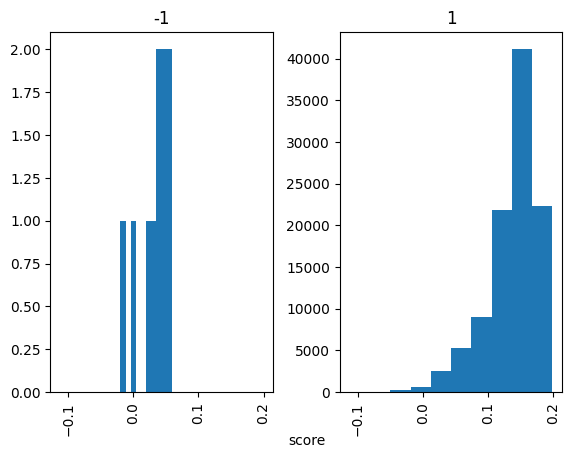

In [88]:
import matplotlib.pyplot as plt
#df_preds[['isInsider', 'scores']].hist(column='scores', by='isInsider', sharex=True)
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True)
df_preds[['isInsider', 'scores']].hist(column='scores', by='isInsider', ax=axes)

fig.text(0.5, 0.04, 'score', ha='center')
#fig.text(0.04, 0.5, 'count', va='center', rotation='vertical')






In [21]:
exp = shap.TreeExplainer(isolation_forest) #Explainer
shap_values = exp.shap_values(X_test)  #Calculate SHAP values
shap.initjs()

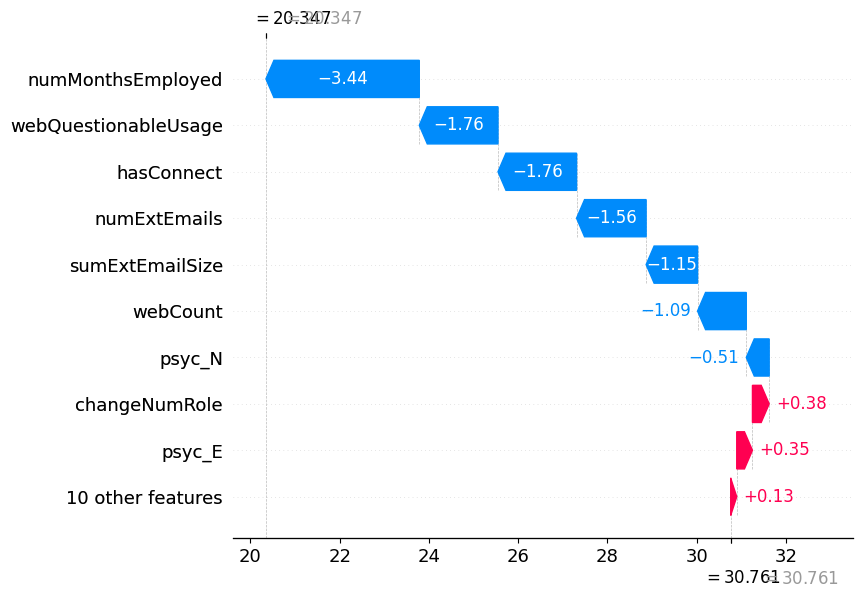

In [95]:
shap.plots._waterfall.waterfall_legacy(exp.expected_value[0], shap_values[61404], feature_names=df_master[features].columns)

In [101]:
test = df_preds.reset_index()
test[(test['isInsider'] == -1) & (test['predictions'] == -1)][['numMonthsEmployed', 'webQuestionableUsage','hasConnect']]

,numMonthsEmployed,webQuestionableUsage,hasConnect
61404,9,26.0,3.0
86952,9,14.0,3.0


In [106]:
test['hasConnect'].mean()

0.40381782945736433